# E-V curve calculation

In Ab-initio calculations, we usually use the so called E-V curve in order to determine the minimum energy lattice parameter for a given setup. It's very simple: You calculate the total energy of the system for various lattice parameters, fit the curve and determine the minimum energy lattice parameter.

In [1]:
from pyiron_workflow import Workflow, function_node

In [2]:
from ase.atoms import Atoms
from ase.build import bulk
import matplotlib.pylab as plt

In [3]:
from atomistics.workflows import optimize_positions_and_volume
from atomistics.workflows.evcurve.helper import (
    analyse_structures_helper,
    generate_structures_helper,
)
from atomistics.calculators import (
    evaluate_with_lammpslib,
    get_potential_by_name,
)

/home/jovyan/dev/atomistics/atomistics/calculators/__init__.py:63: UserWarning: calc_static_with_qe(), evaluate_with_qe() and optimize_positions_and_volume_with_qe() are not available as the import of the module named 'pwtools' failed.
  raise_warning(module_list=quantum_espresso_function, import_error=e)
/home/jovyan/dev/atomistics/atomistics/calculators/lammps/__init__.py:41: UserWarning: calc_molecular_dynamics_phonons_with_lammpslib() is not available as the import of the module named 'dynaphopy' failed.
  raise_warning(module_list=lammps_phonon_functions, import_error=e)
/home/jovyan/dev/atomistics/atomistics/calculators/__init__.py:94: UserWarning: calc_molecular_dynamics_phonons_with_lammpslib() is not available as the import of the module named 'dynaphopy' failed.
  raise_warning(module_list=lammps_phonon_functions, import_error=e)
/home/jovyan/dev/atomistics/atomistics/calculators/__init__.py:104: UserWarning: evaluate_with_sphinx() is not available as the import of the module

In [4]:
@Workflow.wrap.as_function_node
def evcurve_generate_structures(structure: dict, vol_range: float, num_points: int) -> dict:
    return {
        "calc_energy": generate_structures_helper(
            structure=structure["structure_with_optimized_positions_and_volume"],
            vol_range=vol_range,
            num_points=num_points,
        ),
    }

In [5]:
@Workflow.wrap.as_function_node("analyse")
def evcurve_analyse_structures(output_dict: dict, structure_dict: dict, fit_type: str = "polynomial", fit_order: int = 3) -> dict:
    return analyse_structures_helper(
        output_dict=output_dict,
        structure_dict=structure_dict["calc_energy"],
        fit_type=fit_type,
        fit_order=fit_order,
    )

In [6]:
@Workflow.wrap.as_function_node("bulk")
def get_bulk(name, cubic=True):
    return bulk(name=name, cubic=cubic)

In [7]:
@Workflow.wrap.as_function_node
def evaluate(task_dict, potential_dataframe):
    return evaluate_with_lammpslib(task_dict=task_dict, potential_dataframe=potential_dataframe)

In [13]:
import numpy as np
import matplotlib.pyplot as plt

L = 1.0         # Length of the bar [m]
n = 10          # Number of elements
g = 9.81        # Mean gravitational acceleration on earth [m/s^2]

@Workflow.wrap.as_function_node
def create_mesh(n, L):
    nodes = np.linspace(0, L, n + 1)
    h = L / n
    return nodes, h

@Workflow.wrap.as_function_node
def assemble_stiffness_matrix(n, h, rho, g, E):
    a = np.ones((1, n + 1))[0]
    b = np.ones((1, n))[0]
    K = -2 * np.diag(a, 0) + np.diag(b, -1) + np.diag(b, 1)
    K[0, 0] = K[-1, -1] = -1
    K *= -E / h
    F = 2 * np.ones(n + 1)
    F[0] = F[-1] = 1
    F *= rho * g * h / 2
    return K, F

@Workflow.wrap.as_function_node
def apply_boundary_conditions(K, F):
    K[0, :] = 0
    K[0, 0] = 1
    F[0] = 0
    return K, F

@Workflow.wrap.as_function_node
def solve_equation(K, F):
    return np.linalg.solve(K, F)


@Workflow.wrap.as_function_node
def plot_results(nodes, u):
    plt.plot(nodes, u, marker='o')
    plt.xlabel('x [m]')
    plt.ylabel('Displacement u(x) [m]')
    plt.title('Axial Displacement of a 1D Bar')
    plt.grid(True)
    return plt



In [9]:
@Workflow.wrap.as_function_node
def get_murnaghan_results(fit_dict):
    E = fit_dict["bulkmodul_eq"] * 1e9
    v = fit_dict["volume_eq"] * 1e-30
    return E, v

@Workflow.wrap.as_function_node
def get_mass(structure):
    return np.mean(structure.get_masses()) * 1e-3 / 6.022e23

@Workflow.wrap.as_function_node
def get_density(mass, volume):
    return mass / volume

In [15]:
wf = Workflow("EV")
wf.bulk = get_bulk(name="Al")
wf.potential = function_node(get_potential_by_name, potential_name="1999--Mishin-Y--Al--LAMMPS--ipr1")
wf.opt_task_dict = function_node(optimize_positions_and_volume, structure=wf.bulk)
wf.opt_result_dict = evaluate(task_dict=wf.opt_task_dict, potential_dataframe=wf.potential)
wf.structure_dict = evcurve_generate_structures(structure=wf.opt_result_dict, vol_range=0.05, num_points=11)
wf.result_dict = evaluate(task_dict=wf.structure_dict, potential_dataframe=wf.potential)
wf.fit_dict = evcurve_analyse_structures(output_dict=wf.result_dict, structure_dict=wf.structure_dict, fit_type="polynomial", fit_order=3)
wf.murnaghan_results = get_murnaghan_results(wf.fit_dict)
wf.mass = get_mass(wf.bulk)
wf.rho = get_density(wf.mass, wf.murnaghan_results.outputs.v)

In [16]:
wf.mesh = create_mesh(n=n, L=L)
wf.stiffness_matrix = assemble_stiffness_matrix(n=n, h=wf.mesh.outputs.h, rho=wf.rho, g=g, E=wf.murnaghan_results.outputs.E)
wf.boundary_conditions = apply_boundary_conditions(K=wf.stiffness_matrix.outputs.K, F=wf.stiffness_matrix.outputs.F)
wf.results = solve_equation(K=wf.boundary_conditions.outputs.K, F=wf.boundary_conditions.outputs.F)
wf.plot = plot_results(nodes=wf.mesh.outputs.nodes, u=wf.results)

/home/jovyan/dev/atomistics/atomistics/calculators/lammps/potential.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pot["Config"] = config_lst


{'plot__plt': <module 'matplotlib.pyplot' from '/home/jovyan/conda/lib/python3.12/site-packages/matplotlib/pyplot.py'>}

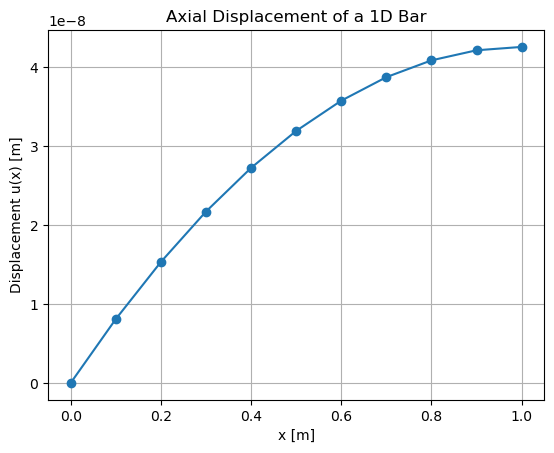

In [17]:
wf.run()